In [2]:
import cupy as cp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from numba.core.errors import NumbaPerformanceWarning
import numpy as np
import os
import pickle
import sys
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
os.environ['CUPY_ACCELERATORS'] = 'cub,cutensor'

sys.path.append('..')
from src import *

# Use `ipympl` for VS Code and `inline` for Jupyter/Jupyterlab
%matplotlib ipympl

The lattice constant for the triangular lattice potential we use is much larger than that of the graphene lattice, so we first need to determine the ideal box width that will simultaneously satisfy periodic boundary conditions for both. The `ideal_boxwidth()` function compares the two lattices and various box sizes up to the `target_width` and returns the box widths in the order of the smallest to the largest error. For the best simulation accuracy, it is ideal to use a box width that is zero or as close to zero as possible.

In [3]:
ideal_tri_lc(max_error=0.01, max_width=210, tri_lc=8.1, kag_lc=0.246, target_width=300, show_topn=5)

Closest tri_lc value found at: 7.872


Triangular lattice test widths (first and last value): 15.744, 299.13599999999997

Kagome lattice test widths (first and last value): 15.744, 300.12

Top 5 ideal box widths (sorted by L2-norm error between lattice dimensions):
#1: 204.672nm | L2-norm error: 0.0000
#2: 54.858nm | L2-norm error: 0.2460
#3: 55.104nm | L2-norm error: 0.4261
#4: 54.612nm | L2-norm error: 0.4920
#5: 204.426nm | L2-norm error: 0.4920


With this we can choose the boxwidth with a low comparison error that is large enough for our needs. The left subplot below shows the molecules overlayed on top of the triangular lattice energy surface. The right subplot shows the Voronoi plot of each molecule with its nearest-neighboring molecules as a number of disclinations, which is one of many potentially useful indicators of phase.

Testing your desired parameters prior to running an experiment will help avoid any issues at runtime.

In [3]:
# boxwidth    = 204.672  # Simulation box width in nanometers
# n_molecules = 1200      # Number of molecules to generate #400, 800, 1200, 1600, 2000
# threshold   = 18       # Minimum distance (in lattice constants) between initial molecule positions #17, 12, 9, 8, 7

# # Define the Kagome lattice object for the simulation (all its parameters are shown here)
# # Note that the data types defined here are used for the entire simulation
# kagome = KagomeLattice(
#     boxwidth=boxwidth, 
#     lattice_constant=0.246, 
#     energy_barrier=275.0, 
#     debye_freq=10e10, 
#     transition_type='t', 
#     intdtype='int32', 
#     floatdtype='float64'
# )

# # The ".get_latticesites()" method to get the array of all lattice sites xy-coordinates
# # An array of position indices can also be passed to get the xy-coordinates of specific lattice sites
# lxy = kagome.get_latticesites(site_numbers=None)

# # The ".get_sitennids()" method retrieves the array of all nearest neighbor indices for each lattice site
# lnnids = kagome.get_sitennids(site_numbers=cp.arange(lxy.shape[0], dtype=kagome._idtype))

# # The ".generate_randomids()" method generates random molecule positions on the lattice
# if n_molecules > 0: 
#     mids = kagome.generate_randomids(
#         n_molecules=n_molecules, 
#         sites=lxy, 
#         n_attempts=1000, 
#         threshold=threshold
#     )

# # The TriangularLatticeEnergies object is used to compute the triangular lattice energy surface
# # The ".U(x,y)" method computes the energy at a given (x,y) position or array of positions
# tle = TriangularLatticeEnergies(lattice_constant=7.872, amplitude=39.8, angle=0., shift=[0., 0.])

# # Compute packing fraction density (for comparison, experiment e8_217.csv was: 0.037308)
# xdim, ydim = kagome.boxsize
# rho = (n_molecules*np.pi*0.48*0.87) / (2*xdim*ydim)
# print(f"System box dimensions (nm): ({kagome.boxsize[0]:.4f}, {kagome.boxsize[1]:.4f})")
# print(f"Number of Kagome unit cells (columns, rows): {kagome.n_unitcells}")
# print(f"Number of total Kagome lattice sites: {kagome._n_totalsites}")
# print(f"Packing fraction density: {rho}")

# # The "plotter.py" module contains some functions to plot the triangular lattice energies, lattice sites, bonds, and molecules
# fig, axs = plt.subplots(1, 2, figsize=(25, 11*figsize_yscale(kagome)), layout='constrained', dpi=72)
# fig.canvas.resizable = False
# # Plot the lattice energy surface
# axs[0] = plot_latticeenergies(axs[0], tle, kagome.boxsize, nsamples=1000, cmap='viridis', alpha=0.75, zorder=1)
# if boxwidth <= 10:
#     # Plot the graphene lattice bonds
#     axs[0] = plot_graphenebonds(axs[0], kagome, colors='b', lw=0.5, ls='--', alpha=0.25, zorder=2)
#     # Plot the Kagome lattice sites
#     axs[0] = plot_kagomesites(axs[0], kagome, s=18, c='k', ec='k', alpha=0.3, zorder=3)
# if n_molecules > 0:
#     # Plot the molecules
#     axs[0] = plot_molecules(axs[0], lxy[lnnids[mids]].get(), show_nn=False, s=35, lw=1.0, mc='tab:red')
# # Plot the hexagonal order parameter
# fig, axs[1] = plot_disclinations(fig, axs[1], kagome, lxy[mids].get())
# for i in range(2):
#     axs[i].set(xlim=kagome.xlim, ylim=kagome.ylim)
#     axs[i].set_xlabel('x (nm)', fontsize=14)
#     axs[i].set_ylabel('y (nm)', fontsize=14)
# plt.show()

### Simulation parameters

Below is the code to start an actual simulation run. The previous lattice object `kagome` is passed to the `simulate()` function, in addition to the previously defined `n_molecules` and `threshold` parameters.

In [4]:
# # Save path for the pickle file containing the simulation data
# save_path = '../data/simdata_test.pkl'

# duration          = 0.001   # Duration of the simulation in seconds
# frames_per_kelvin = 30      # Number of frames to sample per temperature change in Kelvin
# nwarmupsteps      = 100000  # Number of warm-up steps to take before the simulation starts
# progress_freq     = 250000  # Frequency of the progress output in KMC steps
# max_dt            = 60      # Maximum time step interval threshold in seconds

# # Energy parameters for the simulation
# energy_params = {
#     'lattice':'none',  # Lattice energy can either be 'triangular' or 'none'
#     'lattice_params':{
#         'lattice_constant':3.936,  # Lattice constant of the triangular lattice (nm)
#         'amplitude':39.8,          # Amplitude of the triangular lattice energy (meV)
#         'angle':0.0,               # Angle of the triangular lattice (degrees)
#         'shift':[0.0, 0.0]         # Shift of the triangular lattice (nm)
#     },
#     'interaction':'total_impurity',  # Interaction energy parameters
#     'interaction_params':{
#         'Zval':1.0,  # Impurity charge value
#         'epsr':4.22  # Dielectric constant of the medium 
#     }
# }

# # Temperature parameters for the simulation
# temperature_params = {
#     'temp_initial':30,  # Initial temperature of the simulation (K)
#     'temp_final':8.5,   # Final temperature of the simulation (K)
#     'method':'linear'   # Cooling method can be 'linear', 'exponential', or 'inv_exponential'
# }

# # Molecule parameters for the simulation
# molecule_params = {
#     'n_molecules':n_molecules,  # Number of molecules to generate
#     'threshold':threshold,      # Minimum distance (in lattice constants) between initial molecule positions
# }

### Run simulation and save the data

In [5]:
# # Uncomment this cell to run a new simulation and save the data
# # The `simulate()` function is used to run the simulation and return the simulation data as a dictionary
# simdata = simulate(kagome, energy_params, temperature_params, molecule_params, duration, frames_per_kelvin=frames_per_kelvin, nwarmupsteps=nwarmupsteps, progress_freq=progress_freq, max_dt=max_dt)

# # Save the simulation data
# with open(save_path, 'wb') as f:
#     pickle.dump(simdata, f)

### Load saved data

In [6]:
# # Uncomment this cell to load previous simulation data
# with open(save_path, 'rb') as f:
#     simdata = pickle.load(f)

We can see all of the keys contained in `simdata` and an example of some of the data. We can also see that this output also contains all the parameters you need to recreate the simulation if you wanted to.

In [7]:
# print(simdata.keys())
# print(f'\nTotal number of kmc steps: {simdata["n_steps"]}\n')
# print(f'times (in seconds): {simdata["times"].shape}\n{simdata["times"][-10:]}\n')
# print(f'temperatures (in Kelvin): {simdata["temperatures"].shape}\n{simdata["temperatures"][-10:]}\n')
# print(f'ids: {simdata["ids"].shape}\n{simdata["ids"][0,-10:]}')

We can also visualize the simulation and save the animation to a `.gif` or `.mp4` file.

In [8]:
# save_filepath = save_path[:-4]+'.mp4'
# ani = animate_simulation(simdata, save_filepath=save_filepath, frameskip=4, interval=33, repeat=True, figsize=(28, 10), dpi=72) 

In [17]:
def get_test_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        print(data.keys())
    new_data = {
        'ns': data["kmcsteps"][1:],
        'sx': np.arange(data["elapsedtimes"][1:].shape[0]),
        'st': data["times"][1:],
        'dt': data["deltatimes"][1:],
        'et': data["elapsedtimes"][1:],
        'tmps': data["temperatures"][1:],
        'tmp_params': data["temp_params"]
    }
    return new_data

exp10 = get_test_data('../data/mols1200_10us_expTemp_noTle.pkl')
lin10 = get_test_data('../data/mols1200_10us_linTemp_noTle.pkl')
exp100 = get_test_data('../data/mols1200_100us_expTemp_noTle.pkl')
lin100 = get_test_data('../data/mols1200_100us_linTemp_noTle.pkl')

# temp, Ti, Tf, Tcc = temperature_function(0.00001, **exp10['tmp_params'])
# fitcc = Tcc*0.00001*1.1
# print(Tcc, 1/Tcc)
# print(fitcc)

dict_keys(['n_steps', 'n_frames', 'times', 'ids', 'deltatimes', 'temperatures', 'totalenergies', 'globalboops', 'elapsedtimes', 'kmcsteps', 'energy_params', 'temp_params', 'molecule_params', 'lattice_params'])
dict_keys(['n_steps', 'n_frames', 'times', 'ids', 'deltatimes', 'temperatures', 'totalenergies', 'globalboops', 'elapsedtimes', 'kmcsteps', 'energy_params', 'temp_params', 'molecule_params', 'lattice_params'])
dict_keys(['n_steps', 'n_frames', 'times', 'ids', 'deltatimes', 'temperatures', 'totalenergies', 'globalboops', 'elapsedtimes', 'kmcsteps', 'energy_params', 'temp_params', 'molecule_params', 'lattice_params'])
dict_keys(['n_steps', 'n_frames', 'times', 'ids', 'deltatimes', 'temperatures', 'totalenergies', 'globalboops', 'elapsedtimes', 'kmcsteps', 'energy_params', 'temp_params', 'molecule_params', 'lattice_params'])


N samples: 366
First Temp: 29.9666 K | Last Temp: 11.9779 K | Diff: 3.9779 K
Tcc: 309104 | 1/Tcc: 3.23515e-06 | Tcc*duration: 3.09104 | 1/(Tcc*duration): 0.323515
Logs|| Tcc: 12.6414 or 0.079105 | Tcc*duration: 1.12851 | 1/(Tcc*duration): -1.12851 or 0.886125 | duration: -11.5129 or -0.0868589
popt: [-1.57508018e-04  1.00061174e+00]
Estimated et: 152.0888 | Real et: 151.9959 | Error: 0.0930

N samples: 442
First Temp: 29.9667 K | Last Temp: 9.9211 K | Diff: 1.9211 K
Tcc: 30910.4 | 1/Tcc: 3.23515e-05 | Tcc*duration: 3.09104 | 1/(Tcc*duration): 0.323515
Logs|| Tcc: 10.3388 or 0.0967226 | Tcc*duration: 1.12851 | 1/(Tcc*duration): -1.12851 or 0.886125 | duration: -9.21034 or -0.108574
popt: [-1.80849121e-05  1.00728638e+00]
Estimated et: 1275.3923 | Real et: 1266.1666 | Error: 9.2258

N samples: 370
First Temp: 29.9667 K | Last Temp: 11.7234 K | Diff: 3.7234 K
Tcc: 2.2e+06 | 1/Tcc: 4.54545e-07 | Tcc*duration: 22 | 1/(Tcc*duration): 0.0454545
Logs|| Tcc: 14.604 or 0.0684745 | Tcc*duration: 

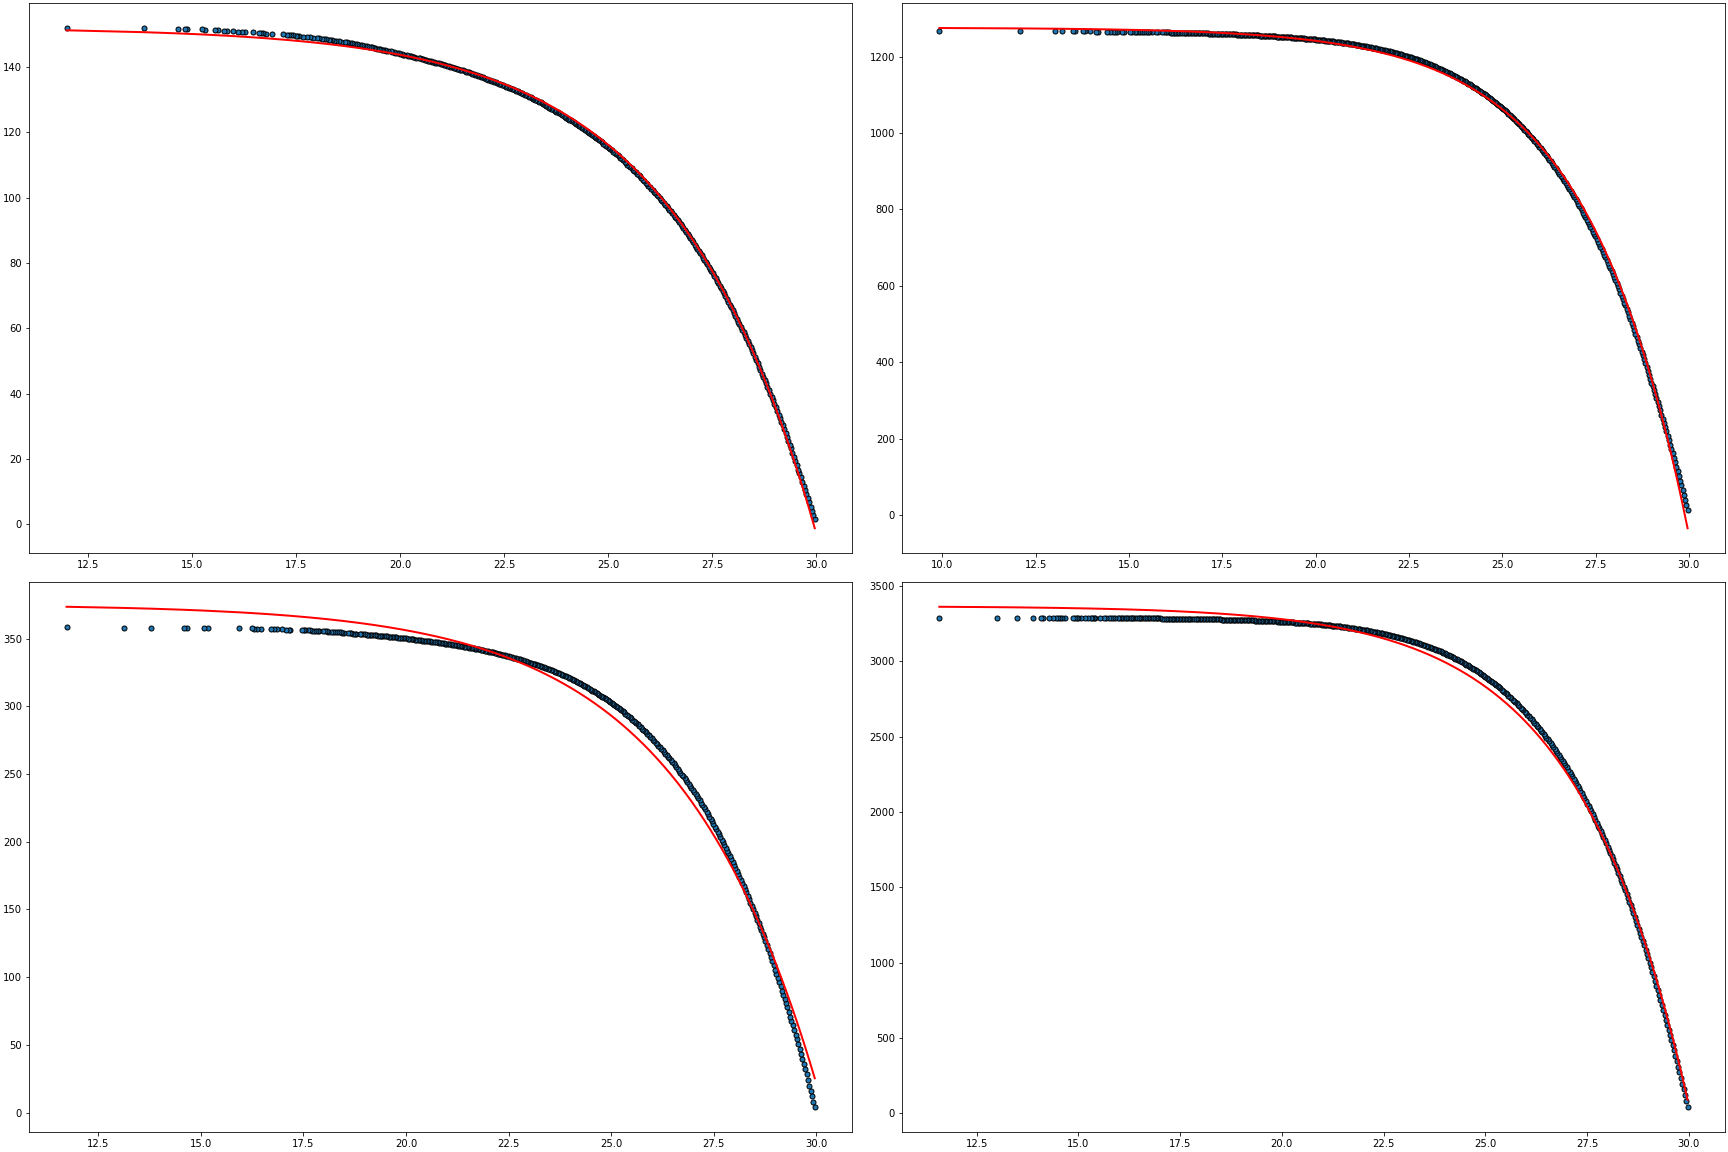

In [10]:
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
plt.close('all')

def get_test_fit(data, duration, nvals=366):
    print(f'N samples: {data["tmps"].shape[0]}')
    max_tmp = data['tmps'][0]
    min_tmp = data['tmps'][-1]
    max_et = data['et'][-1]
    _, _, _, tcc = temperature_function(duration, **data['tmp_params'])
    # _, _, _, tcc = temperature_function(duration, temp_initial=30, temp_final=8, method=data['tmp_params']['method'])
    tccdur = tcc*duration
    invtcc = 1 / (tcc*duration)
    testval = (1/np.log(tcc)) + (-1e2/np.log(duration))
    fit_func = lambda x, a, c: a * np.exp(testval*x) + c

    #timest_func = lambda x, a: a * (1 - np.exp(-x/(Tcc*duration))) 

    tmps = data['tmps'][:nvals] / max_tmp
    et = data['et'][:nvals] / max_et    
    print('First Temp: {:.4f} K | Last Temp: {:.4f} K | Diff: {:.4f} K'.format(max_tmp, min_tmp, min_tmp-8))
    
    print(f'Tcc: {tcc:g} | 1/Tcc: {1/tcc:g} | Tcc*duration: {tccdur:g} | 1/(Tcc*duration): {invtcc:g}')
    print(f'Logs|| Tcc: {np.log(tcc):g} or {1/np.log(tcc):g} | Tcc*duration: {np.log(tccdur):g} | 1/(Tcc*duration): {np.log(invtcc):g} or {1/np.log(tccdur):g} | duration: {np.log(duration):g} or {1/np.log(duration):g}')
    popt, _ = curve_fit(fit_func, tmps, et, p0=[-0.1, 1e4])
    et_fit = fit_func(tmps, *popt) * max_et
    print(f'popt: {popt}')
    print(f'Estimated et: {popt[-1]*max_et:.4f} | Real et: {max_et:.4f} | Error: {popt[-1]*max_et-max_et:.4f}\n')
    return tmps * max_tmp, et_fit, tcc

nvals = 442
exp10['tmps_fit'], exp10['et_fit'], exp10['tcc'] = get_test_fit(exp10, duration=0.00001, nvals=nvals) #366
exp100['tmps_fit'], exp100['et_fit'], exp100['tcc'] = get_test_fit(exp100, duration=0.0001, nvals=nvals) #442
lin10['tmps_fit'], lin10['et_fit'], lin10['tcc'] = get_test_fit(lin10, duration=0.00001, nvals=nvals) #370
lin100['tmps_fit'], lin100['et_fit'], lin100['tcc'] = get_test_fit(lin100, duration=0.0001, nvals=nvals) #442

fig, ax = plt.subplots(2, 2, figsize=(24, 16), layout='constrained', dpi=72)

ax[0,0].plot(exp10['tmps'], exp10['et'], 'o', lw=1, ms=5, mec='k')
ax[0,0].plot(exp10['tmps_fit'], exp10['et_fit'], '-', lw=2, c='r')

ax[0,1].plot(exp100['tmps'], exp100['et'], 'o', lw=1, ms=5, mec='k')
ax[0,1].plot(exp100['tmps_fit'], exp100['et_fit'], '-', lw=2, c='r')

ax[1,0].plot(lin10['tmps'], lin10['et'], 'o', lw=1, ms=5, mec='k')
ax[1,0].plot(lin10['tmps_fit'], lin10['et_fit'], '-', lw=2, c='r')

ax[1,1].plot(lin100['tmps'], lin100['et'], 'o', lw=1, ms=5, mec='k')
ax[1,1].plot(lin100['tmps_fit'], lin100['et_fit'], '-', lw=2, c='r')

plt.show()